In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

Notebook from a talk: can we cherry pick a small number of the most important CVEs using metrics? This explains the case for no.

In [110]:
# Ingest CVEs from the past 15 months, excluding wordpress items (these came from a set of files)
cves = pd.read_csv("nvd-merged.csv", encoding="latin1")
cves = cves[cves['assigner'] != 'cve-request@wordfence.com']
pd.set_option('display.max_rows', 5)
cves

,cve,assigner,cwe,vector,complexity,privileges,interaction,scope,confidentiality,integrity,availability,score,severity,exploitability,impact
0,CVE-2024-0001,psirt@purestorage.com,CWE-1188,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,HIGH,9.8,CRITICAL,3.9,5.9
1,CVE-2024-0002,psirt@purestorage.com,NVD-CWE-noinfo,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,HIGH,9.8,CRITICAL,3.9,5.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44260,CVE-2025-31696,security@drupal.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44261,CVE-2025-31697,security@drupal.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


After excluding Wordpress, there are approx 40k CVEs from the past 15 months, or roughly 2650 per month; 133 per business day assuming a five day week without holidays. We're currently doing 30-40k CVEs per year, which is an order of magnitude larger then a decade ago. If the growth curve continues we could be doing 100-200k per year a decade from now.

There are 1312 CVEs in the KEV at the time of this writing which is approximately 0.48% of the total CVE population of approx 274,000. Can we get anywhere near that level of cherry picking using existing metrics? The answer is no:

In [113]:
kev = pd.read_csv("kev.csv", encoding="latin1")
kev

,cveID,vendorProject,product,vulnerabilityName,dateAdded,shortDescription,requiredAction,dueDate,knownRansomwareCampaignUse,notes,cwes
0,CVE-2024-20439,Cisco,Smart Licensing Utility,Cisco Smart Licensing Utility Static Credentia...,2025-03-31,Cisco Smart Licensing Utility contains a stati...,"Apply mitigations per vendor instructions, fol...",2025-04-21,Unknown,https://sec.cloudapps.cisco.com/security/cente...,CWE-912
1,CVE-2025-2783,Google,Chromium Mojo,Google Chromium Mojo Sandbox Escape Vulnerability,2025-03-27,Google Chromium Mojo on Windows contains a san...,"Apply mitigations per vendor instructions, fol...",2025-04-17,Unknown,https://chromereleases.googleblog.com/2025/03/...,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1310,CVE-2019-8394,Zoho,ManageEngine,Zoho ManageEngine ServiceDesk Plus (SDP) File ...,2021-11-03,Zoho ManageEngine ServiceDesk Plus (SDP) conta...,Apply updates per vendor instructions.,2022-05-03,Unknown,https://nvd.nist.gov/vuln/detail/CVE-2019-8394,CWE-434
1311,CVE-2020-29583,Zyxel,Multiple Products,Zyxel Multiple Products Use of Hard-Coded Cred...,2021-11-03,"Zyxel firewalls (ATP, USG, VM) and AP Controll...",Apply updates per vendor instructions.,2022-05-03,Unknown,https://nvd.nist.gov/vuln/detail/CVE-2020-29583,CWE-522


In [114]:
#these need to be numbers
for field in ['score', 'impact', 'exploitability']:
    cves.loc[:, field] = pd.to_numeric(cves[field], errors='coerce').fillna(0)

In [115]:
#how many fields have NaN values
fields_to_check = ['vector', 'complexity', 'privileges', 'interaction', 
                   'confidentiality', 'integrity', 'availability', 'severity']

for field in fields_to_check:
    # Convert the field to a string and uppercase it, then count where it equals "NAN"
    count_nan = (cves[field].astype(str).str.upper() == 'NAN').sum()
    print(f"Number of rows in '{field}' with 'NAN': {count_nan}")


Number of rows in 'vector' with 'NAN': 21059
Number of rows in 'complexity' with 'NAN': 21059
Number of rows in 'privileges' with 'NAN': 21059
Number of rows in 'interaction' with 'NAN': 21059
Number of rows in 'confidentiality' with 'NAN': 21059
Number of rows in 'integrity' with 'NAN': 21059
Number of rows in 'availability' with 'NAN': 21059
Number of rows in 'severity' with 'NAN': 21059


Let's plot some metrics in the CVEs that we currently use for prioritization;

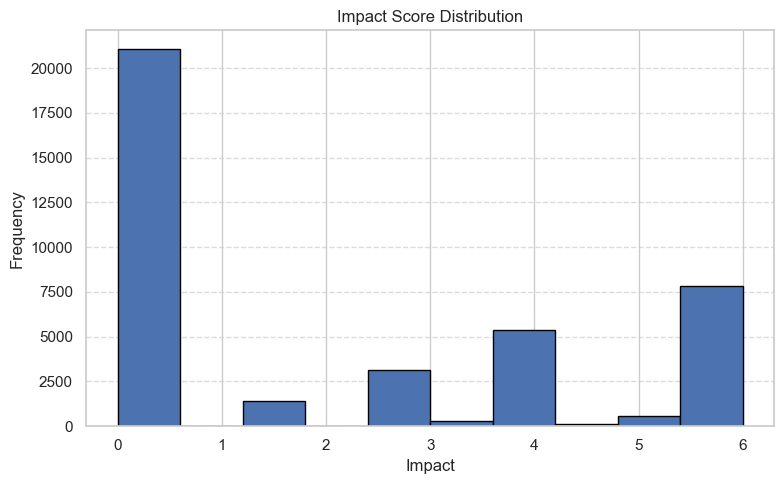

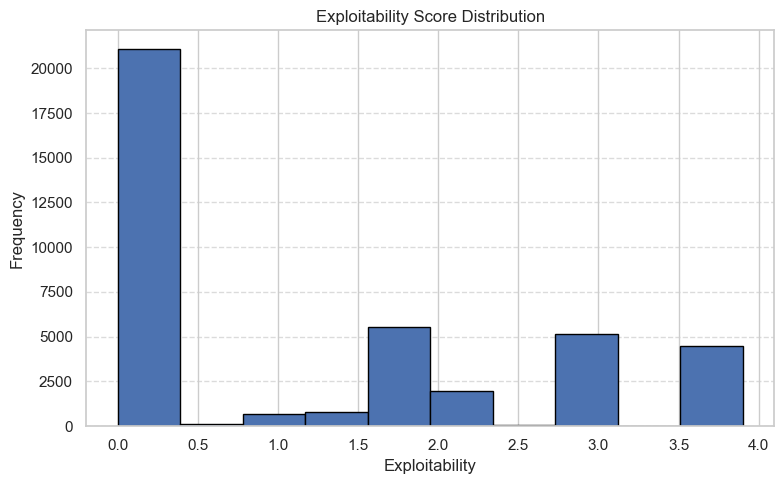

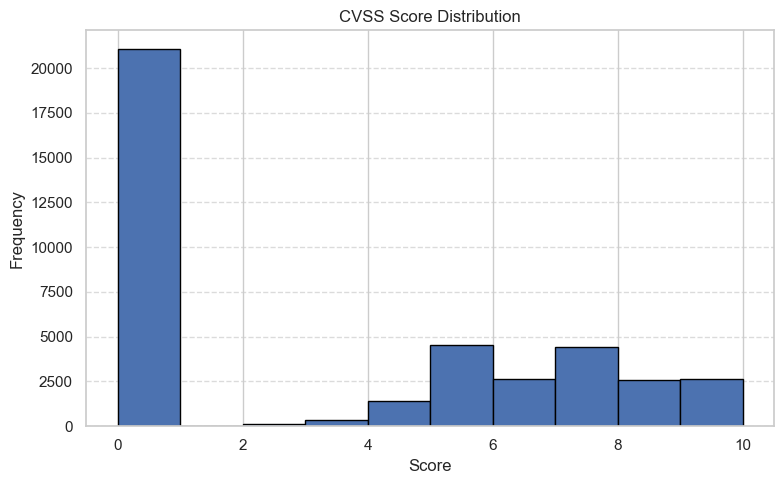

In [117]:
import matplotlib.pyplot as plt

# Impact histogram
plt.figure(figsize=(8, 5))
plt.hist(cves['impact'], bins=10, edgecolor='black')
plt.title("Impact Score Distribution")
plt.xlabel("Impact")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Exploitability histogram
plt.figure(figsize=(8, 5))
plt.hist(cves['exploitability'], bins=10, edgecolor='black')
plt.title("Exploitability Score Distribution")
plt.xlabel("Exploitability")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# CVSS Score histogram
plt.figure(figsize=(8, 5))
plt.hist(cves['score'], bins=10, edgecolor='black')
plt.title("CVSS Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Let's plot some combination histograms

In [119]:
# Create a new column 'score_int' by converting 'score' to integer
cves['score_int'] = cves['score'].astype(float).fillna(0).astype(int)

# Now create the pivot table for plotting
pivot = cves.groupby(['severity', 'score_int']).size().unstack(fill_value=0).sort_index()



In [120]:
pivot = cves.groupby(['severity', 'score_int']).size().unstack(fill_value=0).sort_index()


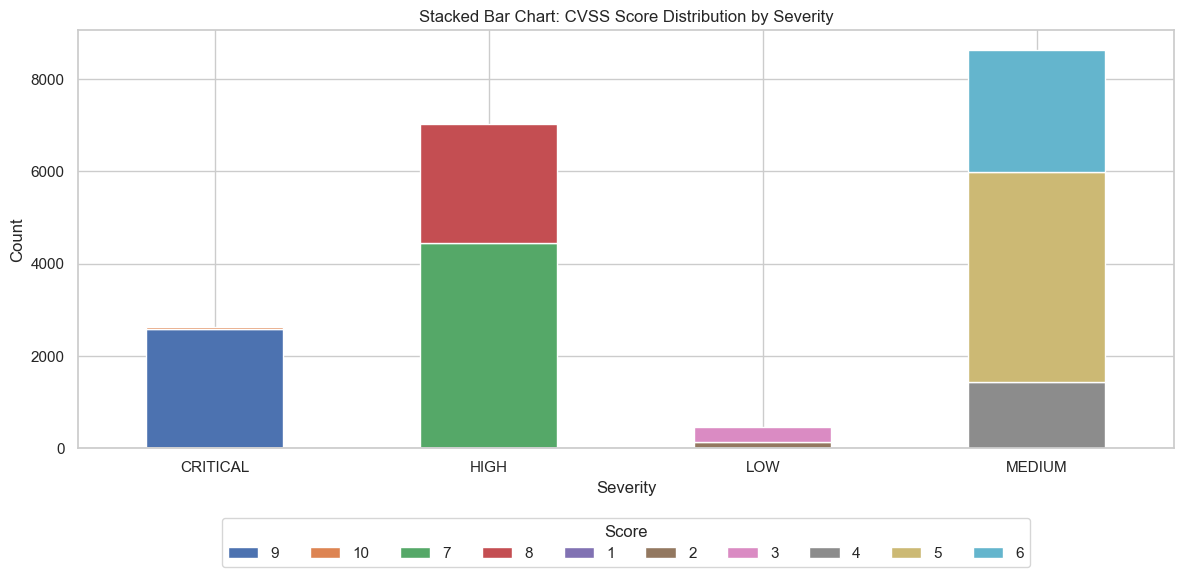

In [121]:
pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6)
)

plt.title("Stacked Bar Chart: CVSS Score Distribution by Severity")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.legend(title="Score", bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(pivot.columns))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [122]:
nonzero = cves[(pd.to_numeric(cves['exploitability'], errors='coerce') != 0) &
               (pd.to_numeric(cves['score'], errors='coerce') != 0) &
               (pd.to_numeric(cves['impact'], errors='coerce') != 0)]

Let's make some scatter plots of some of these field combinations;

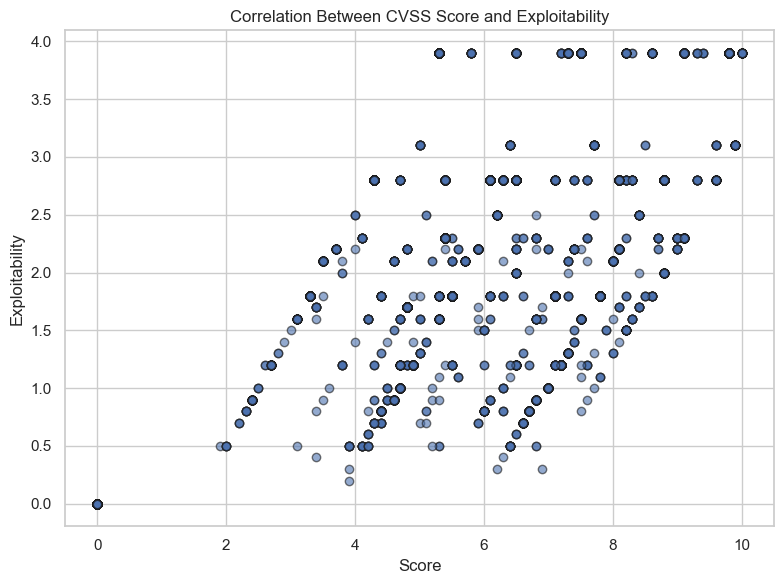

In [124]:

plt.figure(figsize=(8, 6))
plt.scatter(cves['score'], cves['exploitability'], alpha=0.6, edgecolors='k')
plt.title("Correlation Between CVSS Score and Exploitability")
plt.xlabel("Score")
plt.ylabel("Exploitability")
plt.grid(True)
plt.tight_layout()
plt.show()


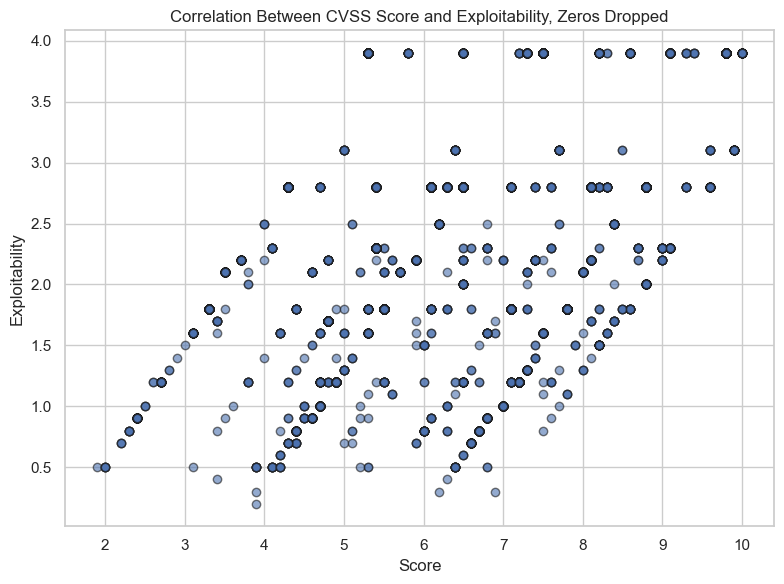

In [125]:

plt.figure(figsize=(8, 6))
plt.scatter(nonzero['score'], nonzero['exploitability'], alpha=0.6, edgecolors='k')
plt.title("Correlation Between CVSS Score and Exploitability, Zeros Dropped")
plt.xlabel("Score")
plt.ylabel("Exploitability")
plt.grid(True)
plt.tight_layout()
plt.show()


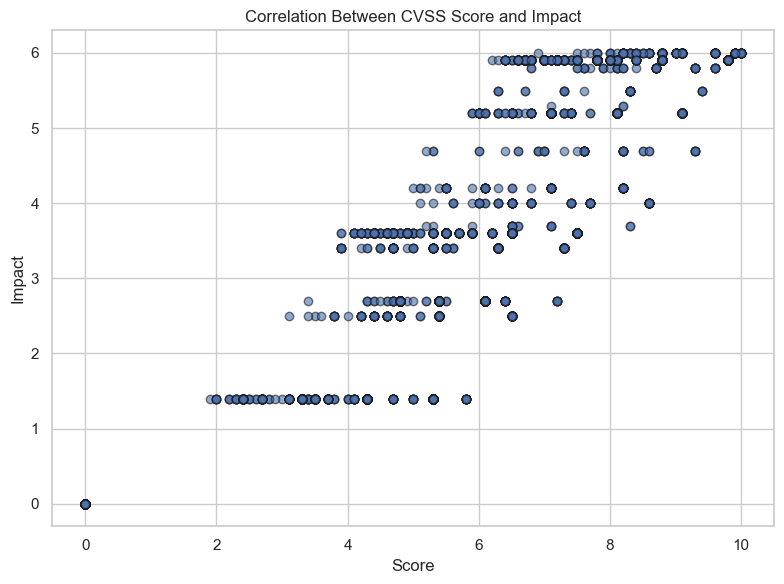

In [126]:

plt.figure(figsize=(8, 6))
plt.scatter(cves['score'], cves['impact'], alpha=0.6, edgecolors='k')
plt.title("Correlation Between CVSS Score and Impact")
plt.xlabel("Score")
plt.ylabel("Impact")
plt.grid(True)
plt.tight_layout()
plt.show()


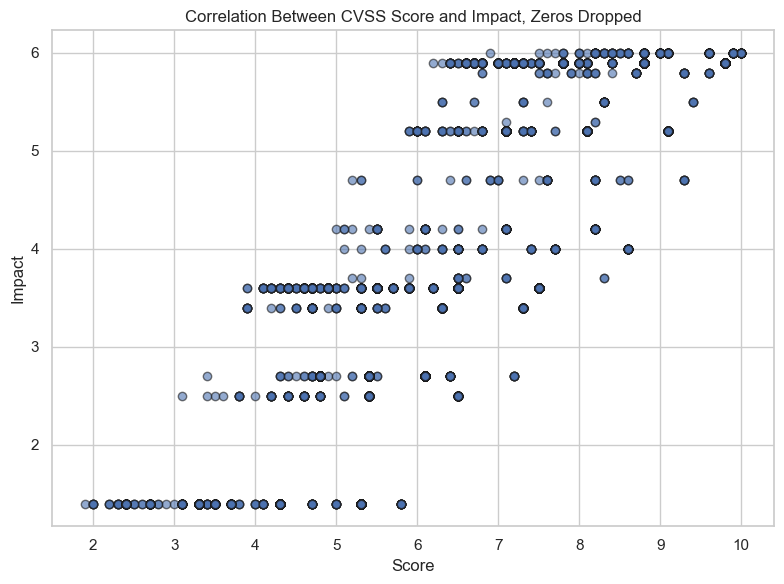

In [127]:

plt.figure(figsize=(8, 6))
plt.scatter(nonzero['score'], nonzero['impact'], alpha=0.6, edgecolors='k')
plt.title("Correlation Between CVSS Score and Impact, Zeros Dropped")
plt.xlabel("Score")
plt.ylabel("Impact")
plt.grid(True)
plt.tight_layout()
plt.show()


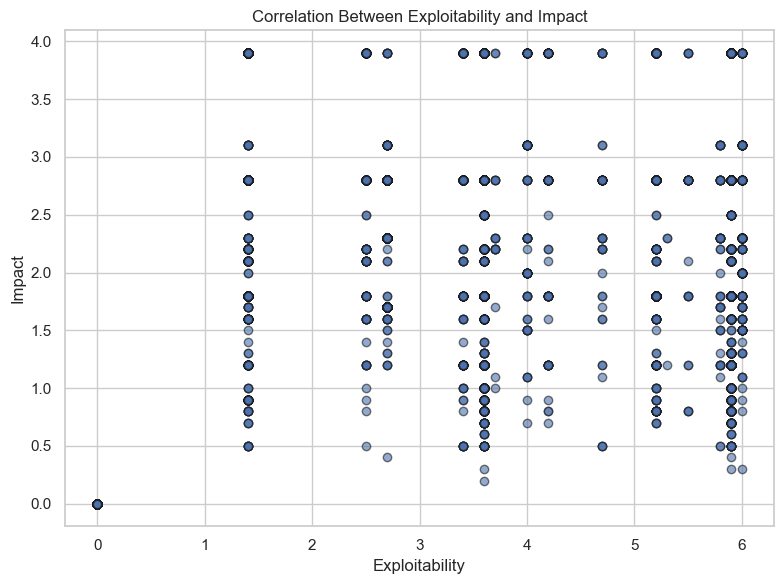

In [128]:
plt.figure(figsize=(8, 6))
plt.scatter(cves['impact'], cves['exploitability'], alpha=0.6, edgecolors='k')
plt.title("Correlation Between Exploitability and Impact")
plt.xlabel("Exploitability")
plt.ylabel("Impact")
plt.grid(True)
plt.tight_layout()
plt.show()

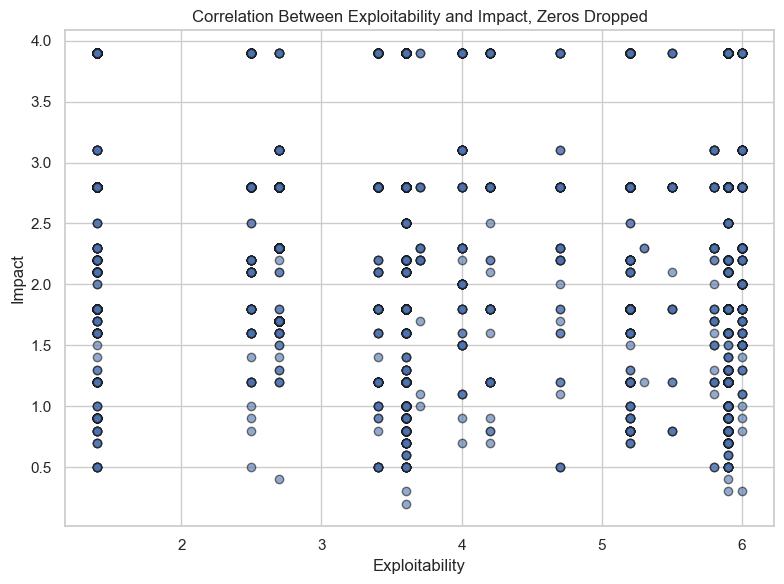

In [129]:
plt.figure(figsize=(8, 6))
plt.scatter(nonzero['impact'], nonzero['exploitability'], alpha=0.6, edgecolors='k')
plt.title("Correlation Between Exploitability and Impact, Zeros Dropped")
plt.xlabel("Exploitability")
plt.ylabel("Impact")
plt.grid(True)
plt.tight_layout()
plt.show()

Maybe some correlations? Let’s calculate them

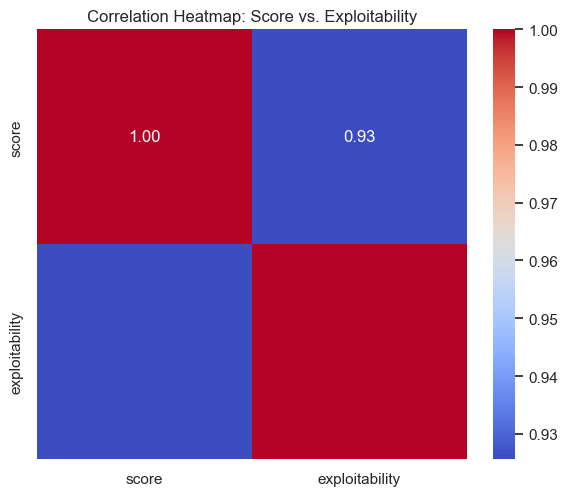

In [131]:
corr = cves[['score', 'exploitability']].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Correlation Heatmap: Score vs. Exploitability")
plt.tight_layout()
plt.show()

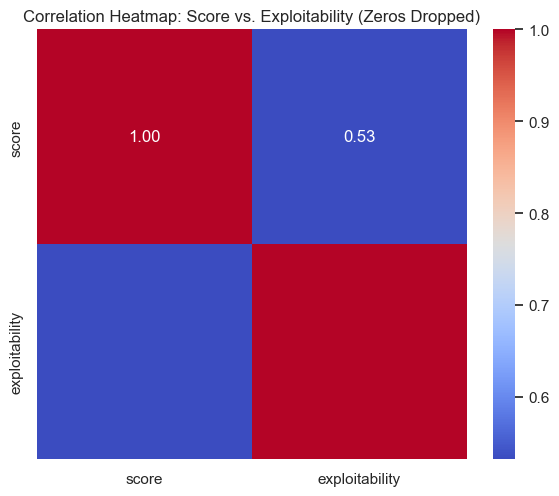

In [132]:

# Calculate correlation on the non zero value set
corr = nonzero[['score', 'exploitability']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Correlation Heatmap: Score vs. Exploitability (Zeros Dropped)")
plt.tight_layout()
plt.show()


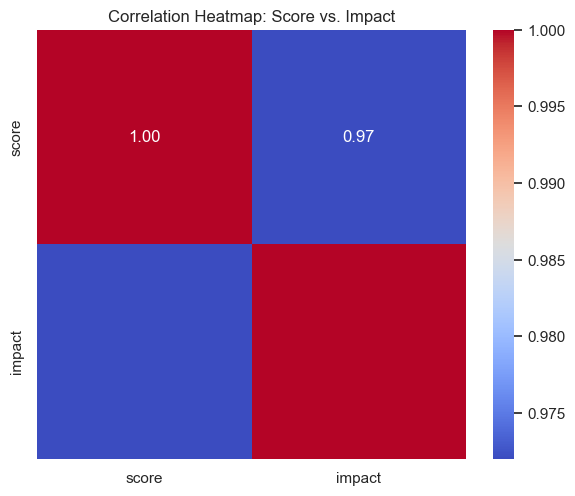

In [133]:
corr = cves[['score', 'impact']].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Correlation Heatmap: Score vs. Impact")
plt.tight_layout()
plt.show()

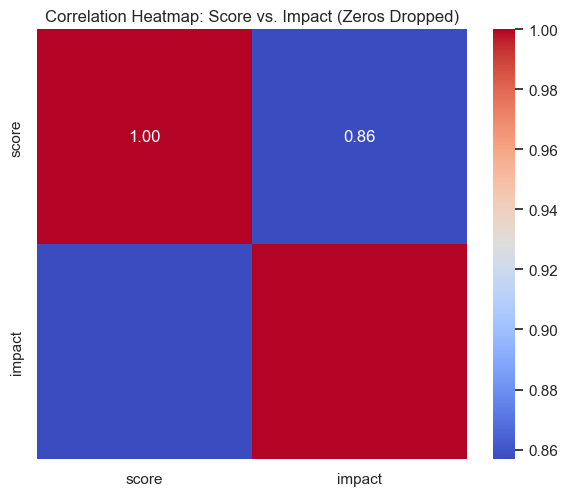

In [134]:
# Calculate correlation on the filtered dataset
corr = nonzero[['score', 'impact']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Correlation Heatmap: Score vs. Impact (Zeros Dropped)")
plt.tight_layout()
plt.show()


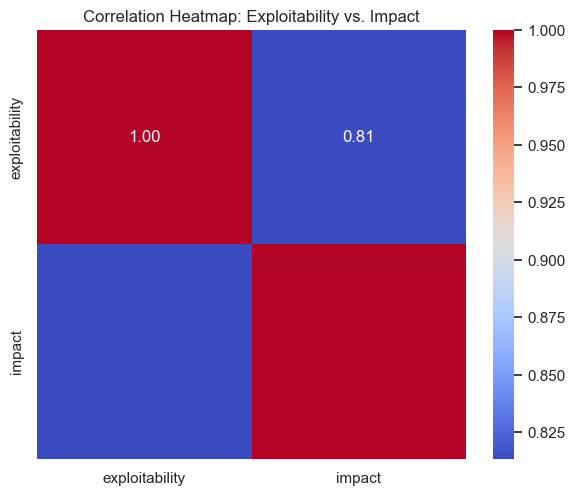

In [135]:
corr = cves[['exploitability', 'impact']].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Correlation Heatmap: Exploitability vs. Impact")
plt.tight_layout()
plt.show()

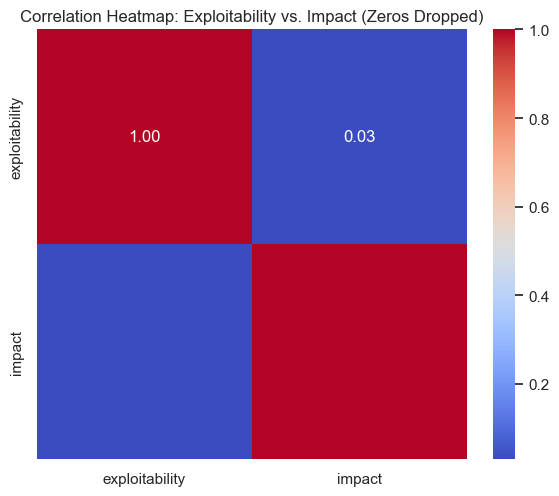

In [136]:
# Calculate correlation on the filtered dataset
corr = nonzero[['exploitability', 'impact']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Correlation Heatmap: Exploitability vs. Impact (Zeros Dropped)")
plt.tight_layout()
plt.show()


Let's plot some metrics for the recent KEV listed CVEs;

Plots of some of the categorical values for the recent KEV listed CVEs;

In [139]:

fields_to_upper = ['vector', 'complexity', 'privileges', 'interaction', 'confidentiality', 'integrity', 'availability']
for field in fields_to_upper:
    cves[field] = cves[field].astype(str).str.upper().fillna('NONE')

conditions = [
    cves['vector'] == 'NETWORK',
    cves['complexity'] == 'LOW',
    cves['privileges'] == 'NONE',
    cves['interaction'] == 'NONE',
    cves['confidentiality'] == 'HIGH',
    cves['integrity'] == 'HIGH',
    cves['availability'] == 'HIGH'
]

# Rows matching ALL conditions
all_conditions = cves[conditions[0]]
for cond in conditions[1:]:
    all_conditions = all_conditions[cond]

all_unique = all_conditions.drop_duplicates()
count_all = len(all_unique)

# Rows matching ANY condition
any_match = cves[
    conditions[0] |
    conditions[1] |
    conditions[2] |
    conditions[3] |
    conditions[4] |
    conditions[5] |
    conditions[6]
]
warnings.filterwarnings("ignore")
any_unique = any_match.drop_duplicates()
count_any = len(any_unique)
print(f"CVEs matching AT LEAST ONE condition: {count_any}")
print(f"Number of CVEs: {len(cves)}")



CVEs matching AT LEAST ONE condition: 18726
Number of CVEs: 39786


So roughly half the CVEs match one of these values. Now let's plot some metric comparisons between the KEV CVEs and the CVE population;

In [141]:
match = cves[cves['cve'].isin(kev['cveID'])].copy()

In [142]:

fields = ['score', 'impact', 'exploitability']
stat_names = ['Mean', 'Median', 'StdDev']

data = []
for label, df in [('All CVEs', cves), ('KEV CVEs', match)]:
    for field in fields:
        series = pd.to_numeric(df[field], errors='coerce').dropna()
        #series = series[series != 0]  # Drop zero values
        data.append({
            'Dataset': label,
            'Field': field.capitalize(),
            'Mean': series.mean(),
            'Median': series.median(),
            'StdDev': series.std()
        })

statsnonzeros = pd.DataFrame(data)
pd.set_option('display.max_rows', 7)
statsnonzeros


,Dataset,Field,Mean,Median,StdDev
0,All CVEs,Score,3.295705,0.0,3.692700
1,All CVEs,Impact,2.021719,0.0,2.384994
2,All CVEs,Exploitability,1.204728,0.0,1.422266
3,KEV CVEs,Score,7.910465,8.2,2.303596
4,KEV CVEs,Impact,5.076744,5.9,1.570948
5,KEV CVEs,Exploitability,2.718605,2.8,1.231365


The large number of zero values is going to skew the data. Let's calculate this again excluding zero values

In [144]:

fields = ['score', 'impact', 'exploitability']
stat_names = ['Mean', 'Median', 'StdDev']

data = []
for label, df in [('Nonzero Score CVEs', nonzero), ('KEV CVEs', match)]:
    for field in fields:
        series = pd.to_numeric(df[field], errors='coerce').dropna()
        series = series[series != 0]  # Drop zero values
        data.append({
            'Dataset': label,
            'Field': field.capitalize(),
            'Mean': series.mean(),
            'Median': series.median(),
            'StdDev': series.std()
        })

statsnonzeros = pd.DataFrame(data)
pd.set_option('display.max_rows', 7)
statsnonzeros


,Dataset,Field,Mean,Median,StdDev
0,Nonzero Score CVEs,Score,7.001810,7.1,1.737843
1,Nonzero Score CVEs,Impact,4.295194,3.6,1.522998
2,Nonzero Score CVEs,Exploitability,2.559476,2.8,0.911081
3,KEV CVEs,Score,8.347239,8.6,1.390324
4,KEV CVEs,Impact,5.357055,5.9,1.045978
5,KEV CVEs,Exploitability,2.868712,2.8,1.080382


Def are some differences there assuming the rows with zero scores would not move the numbers. Let's visualize the differences in these statistics.

In [146]:

melted = statsnonzeros.melt(
    id_vars=['Dataset', 'Field'],
    value_vars=['Mean', 'Median', 'StdDev'],
    var_name='Statistic',
    value_name='Value'
)
pd.set_option('display.max_rows', 20)
#melted

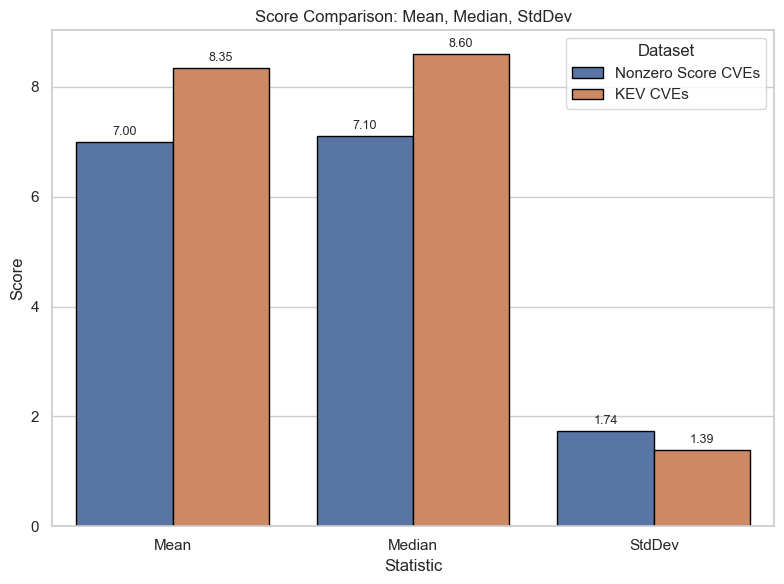

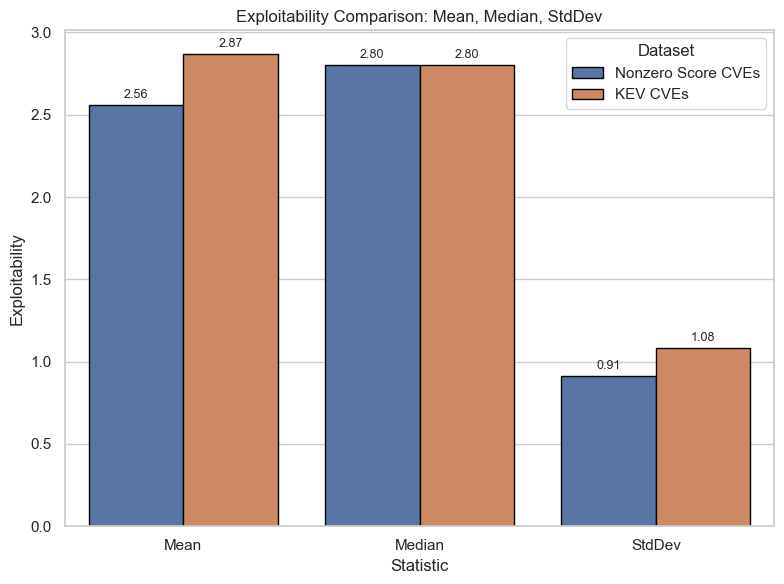

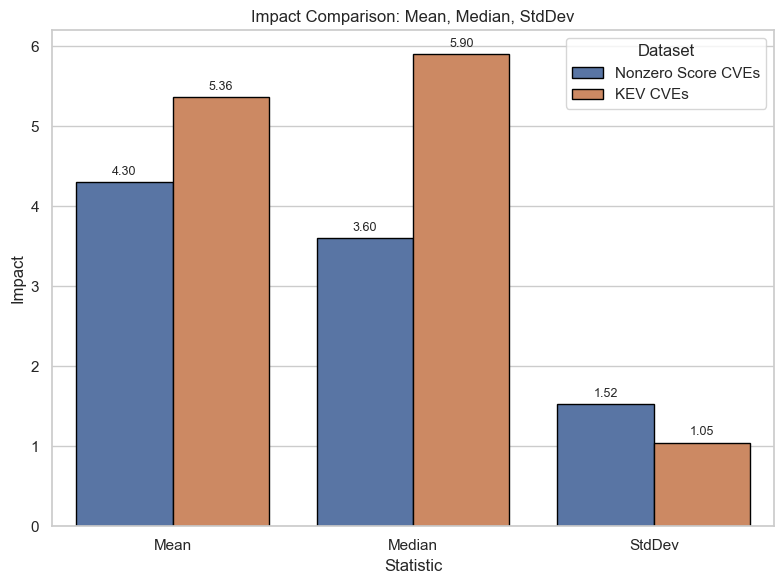

In [147]:


# Make sure your DataFrame is named 'stats_df' or adjust if needed
# It should contain: Dataset | Field | Statistic | Value

sns.set(style="whitegrid")

# Plot for each field
for field in ['Score', 'Exploitability', 'Impact']:
    subset = melted[melted['Field'] == field]

    plt.figure(figsize=(8, 6))
    ax = sns.barplot(
        data=subset,
        x='Statistic',
        y='Value',
        hue='Dataset',
        edgecolor='black'
    )

    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9)

    plt.title(f'{field} Comparison: Mean, Median, StdDev')
    plt.xlabel('Statistic')
    plt.ylabel(field)
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()



So there are some differences between the watchlisted and the general cve population.

In [149]:
statsnonzeros

,Dataset,Field,Mean,Median,StdDev
0,Nonzero Score CVEs,Score,7.001810,7.1,1.737843
1,Nonzero Score CVEs,Impact,4.295194,3.6,1.522998
2,Nonzero Score CVEs,Exploitability,2.559476,2.8,0.911081
3,KEV CVEs,Score,8.347239,8.6,1.390324
4,KEV CVEs,Impact,5.357055,5.9,1.045978
5,KEV CVEs,Exploitability,2.868712,2.8,1.080382


If we take those metrics as thresholds, now many CVEs match?

In [151]:
# Thresholds from KEV CVEs
thresholds = {
    'Score': {'mean': 8.347239, 'median': 8.6},
    'Impact': {'mean': 5.357055, 'median': 5.9},
    'Exploitability': {'mean': 2.868712, 'median': 2.8}
}

# Ensure columns are numeric
for field in ['score', 'impact', 'exploitability']:
    cves[field] = pd.to_numeric(cves[field], errors='coerce')

total = len(cves)
rows = []

for field, values in thresholds.items():
    field_lower = field.lower()
    mean_threshold = values['mean']
    median_threshold = values['median']
    
    count_mean = cves[cves[field_lower] >= mean_threshold].shape[0]
    count_median = cves[cves[field_lower] >= median_threshold].shape[0]
    
    rows.append({
        'Field': field,
        'Mean Threshold': round(mean_threshold, 2),
        'Median Threshold': round(median_threshold, 2),
        'Total': total,
        'Count ≥ Mean': count_mean,
        '% ≥ Mean': f"{(count_mean / total) * 100:.1f}%",
        'Count ≥ Median': count_median,
        '% ≥ Median': f"{(count_median / total) * 100:.1f}%"
    })

threshold_df = pd.DataFrame(rows)
threshold_df



,Field,Mean Threshold,Median Threshold,Total,Count ≥ Mean,% ≥ Mean,Count ≥ Median,% ≥ Median
0,Score,8.35,8.6,39786,4785,12.0%,4756,12.0%
1,Impact,5.36,5.9,39786,7834,19.7%,7755,19.5%
2,Exploitability,2.87,2.8,39786,4537,11.4%,9630,24.2%


In [152]:
# how many CVEs match one of these thresholds
# Thresholds from KEV CVEs
score_mean = 8.347239
score_median = 8.6
impact_mean = 5.357055
impact_median = 5.9
expl_mean = 2.868712
expl_median = 2.8

threshold_matches = cves[
    (cves['score'] >= score_mean) |
    (cves['score'] >= score_median) |
    (cves['impact'] >= impact_mean) |
    (cves['impact'] >= impact_median) |
    (cves['exploitability'] >= expl_mean) |
    (cves['exploitability'] >= expl_median)
].copy()

num_matching = threshold_matches.shape[0]
total_rows = cves.shape[0]
percentage_matching = (num_matching / total_rows) * 100
print(f"Number of matching CVEs: {num_matching}")
print(f"Percentage of total CVEs: {percentage_matching:.2f}%")

#threshold_matches


Number of matching CVEs: 12986
Percentage of total CVEs: 32.64%


So 13k or one-third of the CVEs match one of these thresholds. What about the categorical fields, let's plot those

In [154]:
categorical_field = 'vector'
cves_freq = cves[categorical_field].value_counts(normalize=True) * 100
match_freq = match[categorical_field].value_counts(normalize=True) * 100

print(f"CVEs {categorical_field} distribution (%):\n", cves_freq)
print(f"Match {categorical_field} distribution (%):\n", match_freq)


CVEs vector distribution (%):
 vector
NAN                 52.930679
NETWORK             31.347710
LOCAL               14.185895
ADJACENT_NETWORK     0.962650
PHYSICAL             0.573066
Name: proportion, dtype: float64
Match vector distribution (%):
 vector
NETWORK             69.186047
LOCAL               23.837209
NAN                  5.232558
PHYSICAL             1.162791
ADJACENT_NETWORK     0.581395
Name: proportion, dtype: float64


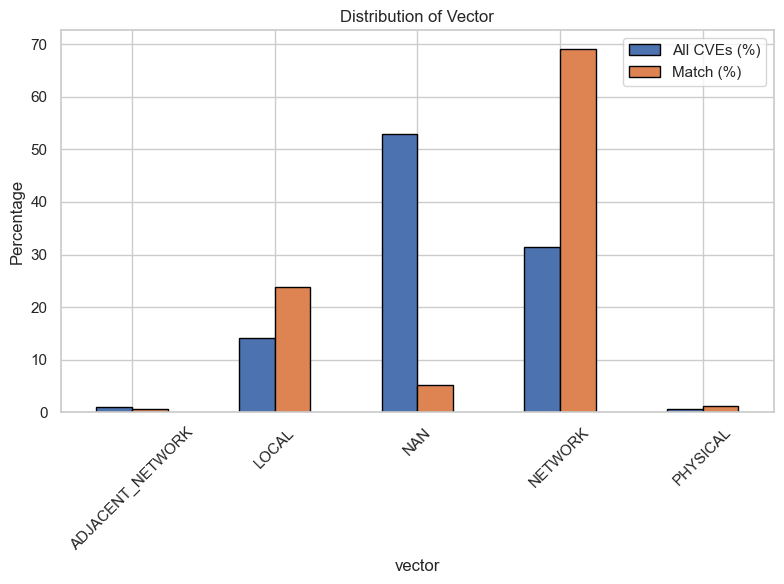

In [155]:
def plot_bar_comparison(field):
    cves_counts = cves[field].fillna('NONE').str.upper().value_counts(normalize=True) * 100
    match_counts = match[field].fillna('NONE').str.upper().value_counts(normalize=True) * 100

    df_compare = pd.DataFrame({
        'All CVEs (%)': cves_counts,
        'Match (%)': match_counts
    }).fillna(0)

    df_compare.plot(kind='bar', figsize=(8, 6), edgecolor='black')
    plt.title(f"Distribution of {field.capitalize()}")
    plt.ylabel("Percentage")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_bar_comparison('vector')


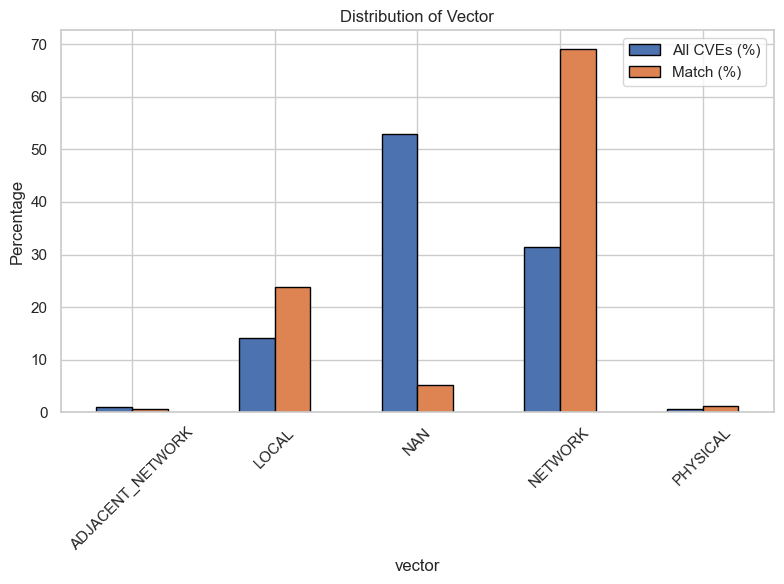

In [156]:
def plot_bar_comparison(field):
    cves_counts = cves[field].value_counts(normalize=True) * 100
    match_counts = match[field].value_counts(normalize=True) * 100

    df_compare = pd.DataFrame({
        'All CVEs (%)': cves_counts,
        'Match (%)': match_counts
    }).fillna(0)

    df_compare.plot(kind='bar', figsize=(8, 6), edgecolor='black')
    plt.title(f"Distribution of {field.capitalize()}")
    plt.ylabel("Percentage")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_bar_comparison('vector')


In [157]:
total = len(cves)
vectors = cves[cves['vector'].isin(['LOCAL', 'NETWORK'])].copy()
percentage = (len(vectors) / total) * 100

print('statistics on the number of CVEs with a local or network vector:')
print(f"Matching rows: {len(vectors)}")
print(f"Percentage: {percentage:.2f}%")


statistics on the number of CVEs with a local or network vector:
Matching rows: 18116
Percentage: 45.53%


In [158]:
# Combine both dataframes
combined_df = pd.concat([vectors, threshold_df], ignore_index=True)

# Drop duplicates based on the 'cve' column, keeping the first occurrence
combined_df = combined_df.drop_duplicates(subset='cve', keep='first')

# Count how many CVEs from this combined set are in the 'cves' dataframe
match_count = cves[cves['cve'].isin(combined_df['cve'])].shape[0]
percentage = (match_count / len(cves)) * 100

print('Statistics on the number of CVEs matching either test:')
print("Number of matching rows in cves:", match_count)
print(f"Percentage: {percentage:.2f}%")


Statistics on the number of CVEs matching either test:
Number of matching rows in cves: 18116
Percentage: 45.53%


So this combination of factors cuts the total by half but we still have 18116 CVEs to consider from the past fifteen months, over 1200  per month, so using metrics likes scores and vectors to select CVEs which resemble watchlisted CVEs still gives us too many CVEs and does not get us anywhere near the half pecent in the watchlist. The problem is compounded by missing metrics and scores in a portion of the CVEs.